Task 2: In this notebook, we utilize K-means clustering algorithm to find distance between grayscale satellite images (pixelated). These images are processed using OpenCV library and converted into binary where white pixels denote city lights. The output consists of images indicating location of cities (centroids) along with there coordinates & also prints the distance between them.

Note: In this version of code, there is no need to input the number of clusters seperately for each image. It is automatically calculated by elbow method!

In [126]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
from tabulate import tabulate

In [127]:
def kmeans(points, centroids, max_iters=100, tol=1e-4):
    for _ in range(max_iters):
        # Step 1: Assigning points to nearest centroid
        distances = np.sqrt(((points - centroids[:, np.newaxis])**2).sum(axis=2))
        cc_indices = np.argmin(distances, axis=0)

        # Step 2: Calculating new centroids
        new_centroids = np.array([points[cc_indices == k].mean(axis=0) for k in range(len(centroids))])

        # Checking for convergence
        if np.linalg.norm(new_centroids - centroids) < tol:
            break

        centroids = new_centroids

    return centroids, cc_indices

In [128]:
def calculate_wcss(points, labels, centroids):
    wcss = 0
    for k in range(len(centroids)):
        cluster_points = points[labels == k]
        wcss += np.sum((cluster_points - centroids[k])**2)
    return wcss

In [129]:
def process_img(img_file):
    # Read binary satellite image
    img = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)

    # Apply thresholding to ensure binary img
    _, binary_img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

    # Get coordinates of white pixels (city lights in night image)
    points = np.column_stack(np.atleast_1d((binary_img == 255).nonzero()))

    if len(points) == 0:
        raise ValueError("No white pixels found in the image.")

    # Determine the optimal number of clusters using the elbow method
    wcss_values = []
    K_values = range(1, 11)  # Test K values from 1 to 10

    for K in K_values:
        # Initializing centroids (random)
        np.random.seed(42)
        ci_i = np.random.choice(len(points), K, replace=False)
        centroids = points[ci_i]

        # K-means clustering
        ci_f, labels = kmeans(points, centroids)
        wcss = calculate_wcss(points, labels, ci_f)
        wcss_values.append(wcss)

    # Finding optimal K using the elbow method
    n_points = len(wcss_values)
    all_coords = np.vstack((range(n_points), wcss_values)).T
    fp = all_coords[0]
    lp = all_coords[-1]

    line_vec = lp - fp
    line_vec_norm = line_vec / np.linalg.norm(line_vec)

    vec_from_first = all_coords - fp
    scalar_product = np.dot(vec_from_first, line_vec_norm)

    vec_from_first_parallel = np.outer(scalar_product, line_vec_norm)
    vec_to_line = vec_from_first - vec_from_first_parallel
    dist_to_line = np.linalg.norm(vec_to_line, axis=1)

    ep = np.argmax(dist_to_line)
    optimal_K = ep + 1

    # K-means clustering with optimal K
    np.random.seed(42)
    ci_i = np.random.choice(len(points), optimal_K, replace=False)
    centroids = points[ci_i]
    ci_f, labels = kmeans(points, centroids)

    # Printing detected city coordinates (centroids)
    cities = {}
    for idx, centroid in enumerate(ci_f):
        cities[f'City{idx+1}'] = (centroid[1], centroid[0])
        print(f"City {idx+1}: (x={centroid[1]}, y={centroid[0]})")
    print()
    
    # Calculating distances between the cities
    def calculate_distances(cities):
        city_names = list(cities.keys())
        distances = []
        for i in range(len(city_names)):
            for j in range(i + 1, len(city_names)):
                city1, city2 = city_names[i], city_names[j]
                coord1, coord2 = cities[city1], cities[city2]
                distance = euclidean(coord1, coord2)
                distances.append((city1, city2, distance))
        return distances

    city_distances = calculate_distances(cities)

    # Convert distances to DataFrame for tabular printing
    print("Distances between cities are as follows: ")
    distances_df = pd.DataFrame(city_distances, columns=["City1", "City2", "Distance"])
    print(tabulate(distances_df, tablefmt='grid', showindex=False))

    # Visualizing the result
    plt.imshow(binary_img, cmap='gray')
    plt.scatter(points[:, 1], points[:, 0], c=labels, s=1)
    plt.scatter(ci_f[:, 1], ci_f[:, 0], c='red', marker='x')
    for idx, centroid in enumerate(ci_f):
        plt.text(centroid[1], centroid[0], f'   City{idx+1}', color='red', weight='bold')
    plt.show()

Processing img: 1.png

City 1: (x=40.81395348837209, y=38.93023255813954)
City 2: (x=16.456521739130434, y=33.43478260869565)
City 3: (x=58.425, y=19.7)

Distances between cities are as follows: 
+-------+-------+---------+
| City1 | City2 | 24.9697 |
+-------+-------+---------+
| City1 | City3 | 26.0759 |
+-------+-------+---------+
| City2 | City3 | 44.1588 |
+-------+-------+---------+


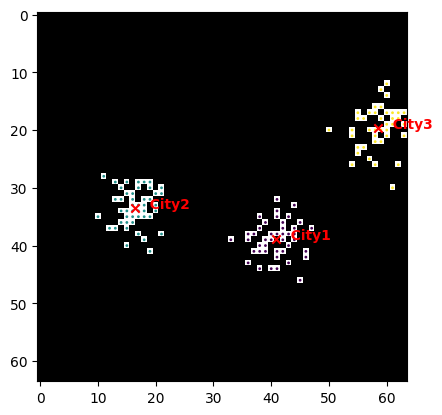

Processing img: 2.png

City 1: (x=23.103448275862068, y=48.62068965517241)
City 2: (x=40.54545454545455, y=44.90909090909091)
City 3: (x=28.82051282051282, y=26.384615384615383)

Distances between cities are as follows: 
+-------+-------+---------+
| City1 | City2 | 17.8325 |
+-------+-------+---------+
| City1 | City3 | 22.9593 |
+-------+-------+---------+
| City2 | City3 | 21.9233 |
+-------+-------+---------+


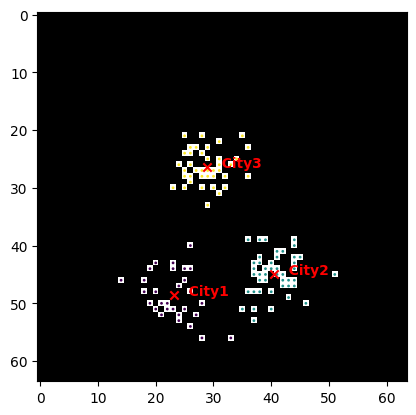

Processing img: 3.png

City 1: (x=49.142857142857146, y=9.257142857142858)
City 2: (x=9.025, y=9.95)
City 3: (x=50.02564102564103, y=49.38461538461539)
City 4: (x=9.418604651162791, y=49.2093023255814)

Distances between cities are as follows: 
+-------+-------+---------+
| City1 | City2 | 40.1238 |
+-------+-------+---------+
| City1 | City3 | 40.1372 |
+-------+-------+---------+
| City1 | City4 | 56.34   |
+-------+-------+---------+
| City2 | City3 | 56.8871 |
+-------+-------+---------+
| City2 | City4 | 39.2613 |
+-------+-------+---------+
| City3 | City4 | 40.6074 |
+-------+-------+---------+


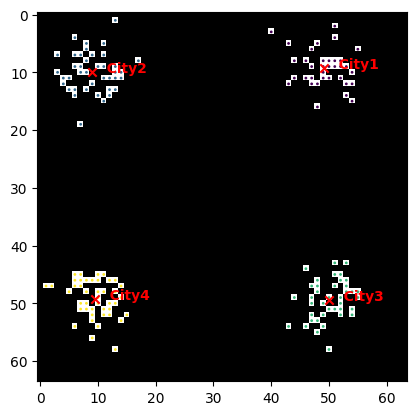

Processing img: 4.png

City 1: (x=57.5, y=38.44736842105263)
City 2: (x=21.075949367088608, y=20.329113924050635)

Distances between cities are as follows: 
+-------+-------+---------+
| City1 | City2 | 40.6815 |
+-------+-------+---------+


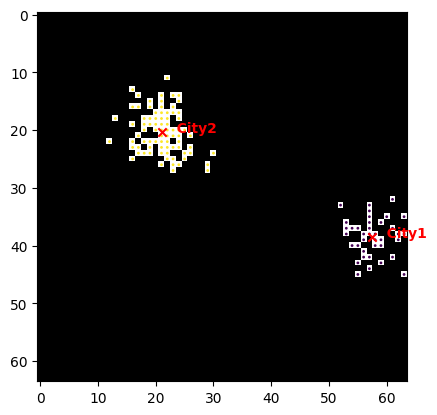

In [130]:
# List of img files
img_files = ["1.png", "2.png", "3.png", "4.png"]

# Processing each image one by one
for img_file in img_files:
    print(f"Processing img: {img_file}")
    print()
    process_img(img_file)